# Analyze Portfolio via a standard process

- Gather stocks of interest
- Gather stocks from specific criteria (SP500 top 50...)
- Gather stocks from specific portfolio account
- Assemble stock universe 
- Gather ticker data
- Generate Risk Profile
- Generate Factors
- Generate Optimal Portfolio
- Report on new portfolio

In [11]:
from platform import python_version
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
import matplotlib as plt

%matplotlib inline

import importlib
import trading_functions as tf
importlib.reload(tf)

portfun = tf.Portfolio()
selfun = tf.Selection()

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
importlib.reload(portfolio_optimizer)

import ameritrade_functions as amc
importlib.reload(amc)

plt.rcParams['figure.figsize'] = (20, 8)
print(f'Python version: {python_version()}')
print(f'Pandas version: {pd.__version__}')

Python version: 3.6.12
Pandas version: 0.22.0


## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

In [4]:
username = os.getenv('maiotradeuser')
password = os.getenv('maiotradepw')
client_id = os.getenv('maiotradeclientid')

masked_account_number = '#---5311'
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = 'data/price_histories_20210424.csv'

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but that has not been coded yet.)

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

In [5]:
td_ameritrade = amc.AmeritradeRest(username, password, client_id)
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    print('Error: No authorization data: {}'.format(td_ameritrade.authorization))
else:
    print('You have authorization')

You have authorization


In [6]:
import trading_factors as alpha_factors
importlib.reload(alpha_factors)
import alphalens as al

def generate_portfolio(investment_amount, stock_universe, price_histories, risk_cap=0.05,weights_max=0.12, weights_min=-0.12, num_factor_exposures=10):
    print(f'Investment amount: {investment_amount}')
    pricing = datafun.get_close_values(price_histories)
    returns = retfun.compute_returns(pricing)
    
    all_factors = pd.concat(
    [
        alpha_factors.momentum(price_histories, 252),
        alpha_factors.mean_reversion_factor_returns_smoothed(price_histories, 5),
        alpha_factors.overnight_sentiment_smoothed(price_histories, 5)
    ], axis=1)
    all_factors.sort_index(inplace=True)

    assets = all_factors.index.levels[1].values.tolist()
    clean_factor_data, unixt_factor_data = alpha_factors.prepare_alpha_lense_factor_data(all_factors, pricing)
    
    
    """
    ls_factor_tears = pd.DataFrame()
    for factor, factor_data in clean_factor_data.items():
        print('Factor: ', factor)
        ls_factor_tears[factor] = al.tears.create_full_tear_sheet(factor_data, long_short=False, group_neutral=False, by_group=False)
        
    display(ls_factor_tears)
    """        
    risk_model = alpha_factors.RiskModelPCA(returns, 1, num_factor_exposures)
    print(f'portfolio variance is:  {risk_model.compute_portfolio_variance(sotck_universe_weights):.8f}')
    
    ls_factor_returns = pd.DataFrame()

    for factor, factor_data in clean_factor_data.items():
        ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]
        
    (1+ls_factor_returns).cumprod().plot()
        
    qr_factor_returns = pd.DataFrame()

    for factor, factor_data in unixt_factor_data.items():
        qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

    (10000*qr_factor_returns).plot.bar(
        subplots=True,
        sharey=True,
        layout=(4,2),
        figsize=(14, 14),
        legend=False)
    
    ls_FRA = pd.DataFrame()

    for factor, factor_data in unixt_factor_data.items():
        ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

    ls_FRA.plot(title="Factor Rank Autocorrelation")
    
    factor_sharp_ratio = alpha_factors.sharpe_ratio(ls_factor_returns, 'daily')
    print(factor_sharp_ratio.round(2))
    
    selected_factors = all_factors.columns[[idx for idx, element in enumerate(factor_sharp_ratio.values) if element >= 0.9]]
    print(selected_factors)
    print('Selected Factors: {}'.format(', '.join(selected_factors)))

    all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
    alphas = all_factors[['alpha_vector']]

    alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]
    
    optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
    print(f'Old portfolio variance is:  {risk_model.compute_portfolio_variance(sotck_universe_weights):.8f}')
    print(f'New portfolio variance is:  {risk_model.compute_portfolio_variance(optimal_weights):.8f}')
    optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
    
    print(f'Current investment amount: {investment_amount}')
    optimal_weights['amount'] = (optimal_weights['optimalWeights'] * investment_amount).round(0)
    optimal_weights['marketValue'] = stock_universe_values['marketValue']
    optimal_weights['buy/sell'] = (optimal_weights['marketValue'] - optimal_weights['amount']) * -1
    optimal_weights['close'] = pricing.iloc[-1]
    optimal_weights['deltaShares'] = (optimal_weights['buy/sell'] / optimal_weights['close']).round(0)
    optimal_weights['deltaMarketValue'] = (optimal_weights['deltaShares'] * optimal_weights['close'])
    optimal_weights['totalShares'] = optimal_weights['deltaShares']
    optimal_weights['totalMarketValue'] = (optimal_weights['totalShares'] * optimal_weights['close'])
    return optimal_weights[(optimal_weights['totalShares'] > 0) & (optimal_weights['deltaShares'] != 0)].round(2)

In [7]:
symbols_of_interest = ['MGM', 'PDYPF', 'NNXPF']
# Hardcoded for now
symbols_via_specific_criteria = ['AAPL', 'MSFT', 'GOOG', 'TSLA', 'COKE', 'IBM', 'BABA']

# Specific Portfolio Account
account_portfolio_df = datafun.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
equity_investments_df = portfun.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
symbols_from_account = list(equity_investments_df['symbol'].values)

stock_universe = set(symbols_of_interest + symbols_via_specific_criteria + symbols_from_account)

In [8]:
non_portfolio_symbols = stock_universe - set(symbols_from_account)
non_portfolio_values = pd.DataFrame.from_dict({ symbol : [0, 0] for symbol in non_portfolio_symbols}, orient='index')
non_portfolio_values.index.name='symbol'
non_portfolio_values.columns = ['marketValue', 'longQuantity']
stock_universe_values = portfun.get_market_values(equity_investments_df).append(non_portfolio_values)
sotck_universe_weights = portfun.get_portfolio_weights(stock_universe_values)
display(sotck_universe_weights)

symbol
AAPL     0.000000
BABA     0.000000
COKE     0.000000
DKNG     0.020696
EEENF    0.000037
FGPHF    0.069046
FNCL     0.029765
GOOG     0.000000
IBM      0.000000
MGM      0.000000
MSFT     0.000000
NNXPF    0.000000
PDYPF    0.000000
SCHA     0.017745
SCHF     0.076347
SCHM     0.052569
TLRY     0.115267
TSLA     0.000000
VBK      0.015948
VBR      0.018795
VGK      0.079426
VTI      0.310267
VXF      0.052674
WKHS     0.141417
dtype: float64

# Price History data

One you have a set of investments you want to work with, you will need to pull some historical data for them.

In [12]:
from trading_functions import Returns
from trading_functions import Data
number_of_years = 5
price_histories = td_ameritrade.get_price_histories(stock_universe, datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
returns = Returns().compute_returns(Data().get_close_values(price_histories))
pricing = Data().get_close_values(price_histories)

## Factors

In [20]:
import trading_factors as alpha_factors
importlib.reload(alpha_factors)
import alphalens as al

In [27]:
all_factors = pd.concat(
[
    alpha_factors.momentum(price_histories, 252),
    alpha_factors.mean_reversion_factor_returns_smoothed(price_histories, 5),
    alpha_factors.overnight_sentiment_smoothed(price_histories, 5)
], axis=1).dropna()
all_factors.sort_index(inplace=True)

all_factors.head()

momentum_252_day_factor_returns  \
date       ticker                                    
2017-05-31 AAPL                           1.523500   
           BABA                           1.233310   
           COKE                           1.668595   
           DKNG                          -0.943119   
           EEENF                         -0.943119   

                   mean_reversion_5_day_factor_returns_smoothed  \
date       ticker                                                 
2017-05-31 AAPL                                        0.072548   
           BABA                                        0.507833   
           COKE                                       -1.668595   
           DKNG                                        1.088214   
           EEENF                                       1.088214   

                   overnight_sentiment_5_day_smoothed  
date       ticker                                      
2017-05-31 AAPL                              1.083708  
           BABA                              1.228203  
           COKE                              1.517192  
           DKNG                             -1.661686  
           EEENF                            -1.011461

## Universal Quant Features

- Volatility 
- Dollar Volume

In [28]:
all_factors = pd.concat(
[
    all_factors,
    alpha_factors.annualized_volatility(price_histories, 20),
    alpha_factors.annualized_volatility(price_histories, 120)
], axis=1).dropna()
all_factors.sort_index(inplace=True)
all_factors.head()

momentum_252_day_factor_returns  \
date       ticker                                    
2017-05-31 AAPL                           1.523500   
           BABA                           1.233310   
           COKE                           1.668595   
           DKNG                          -0.943119   
           EEENF                         -0.943119   

                   mean_reversion_5_day_factor_returns_smoothed  \
date       ticker                                                 
2017-05-31 AAPL                                        0.072548   
           BABA                                        0.507833   
           COKE                                       -1.668595   
           DKNG                                        1.088214   
           EEENF                                       1.088214   

                   overnight_sentiment_5_day_smoothed  \
date       ticker                                       
2017-05-31 AAPL                              1.083708   
           BABA                              1.228203   
           COKE                              1.517192   
           DKNG                             -1.661686   
           EEENF                            -1.011461   

                   annualzed_volatility_20_day  annualzed_volatility_120_day  
date       ticker                                                             
2017-05-31 AAPL                       0.943119                      0.652929  
           BABA                       1.088214                      1.088214  
           COKE                       1.378405                      1.233310  
           DKNG                      -1.378405                     -1.378405  
           EEENF                     -1.378405                     -1.378405

In [19]:

assets = all_factors.index.levels[1].values.tolist()
clean_factor_data, unixt_factor_data = alpha_factors.prepare_alpha_lense_factor_data(all_factors, pricing)

Dropped 19.8% entries from factor data: 19.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.0% entries from factor data: 0.5% in forward returns computation and 0.6% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.8% entries from factor data: 1.4% in forward returns computation and 0.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 9.3% entries from factor data: 9.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


KeyError: 'AAPL'

In [23]:
clean_factor_data

{'momentum_252_day_factor_returns':                         1D    factor  factor_quantile
 date       asset                                     
 2017-05-31 AAPL   0.002749  1.523500                5
            BABA   0.012331  1.233310                5
            COKE   0.015237  1.668595                5
            DKNG   0.000000 -0.943119                1
            EEENF  0.000000 -0.943119                1
            FGPHF  0.000000 -0.943119                1
            FNCL   0.012213  0.652929                4
            GOOG   0.002166  0.798024                4
            IBM    0.000262 -1.378405                1
            MGM    0.017024  1.088214                5
            MSFT   0.003723  0.943119                4
            NNXPF  0.000000 -0.943119                1
            PDYPF  0.000000 -1.523500                1
            SCHA   0.017645  0.072548                3
            SCHF   0.007602 -0.072548                3
            SCHM   0.013871 -0

Investment amount: 86250
Dropped 9.6% entries from factor data: 9.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.9% entries from factor data: 0.5% in forward returns computation and 2.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.4% entries from factor data: 0.8% in forward returns computation and 0.6% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.5% entries from factor data: 0.5% in forward returns computation and 2.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exce

C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\nmaiorana\anacond

                                             Sharpe Ratio
momentum_120_day_factor_returns                     -0.94
mean_revision_5_day_factor_returns                   1.23
mean_revision_5_day_factor_returns_smoothed          0.71
mean_5_day_factor_returns_smoothed                  -1.23
overnight_sentiment_5_day                            3.29
overnight_sentiment_5_day_smoothed                   0.45
Index(['mean_revision_5_day_factor_returns', 'overnight_sentiment_5_day'], dtype='object')
Selected Factors: mean_revision_5_day_factor_returns, overnight_sentiment_5_day
Old portfolio variance is:  0.01968417
New portfolio variance is:  0.05000000
Current investment amount: 86250


,optimalWeights,amount,marketValue,buy/sell,close,deltaShares,deltaMarketValue,totalShares,totalMarketValue
asset,,,,,,,,,
AAPL,0.12,10350.0,0.00,10350.00,125.16,83.0,10388.28,83.0,10388.28
BABA,0.12,10350.0,0.00,10350.00,213.87,48.0,10265.76,48.0,10265.76
EEENF,0.01,741.0,4.43,736.57,0.02,41614.0,736.57,41614.0,736.57
FNCL,0.12,10350.0,3615.99,6734.01,53.92,125.0,6739.59,125.0,6739.59
IBM,0.12,10350.0,0.00,10350.00,143.99,72.0,10367.28,72.0,10367.28
PDYPF,0.12,10350.0,0.00,10350.00,187.19,55.0,10295.45,55.0,10295.45
SCHA,0.12,10350.0,2159.64,8190.36,102.74,80.0,8218.80,80.0,8218.80
SCHM,0.12,10350.0,6399.94,3950.06,77.93,51.0,3974.38,51.0,3974.38
VBR,0.12,10350.0,2285.14,8064.86,175.56,46.0,8075.76,46.0,8075.76


Investment amount: 28750
Dropped 9.6% entries from factor data: 9.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.9% entries from factor data: 0.5% in forward returns computation and 2.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.4% entries from factor data: 0.8% in forward returns computation and 0.6% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.5% entries from factor data: 0.5% in forward returns computation and 2.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exce

C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\nmaiorana\anacond

                                             Sharpe Ratio
momentum_120_day_factor_returns                     -0.94
mean_revision_5_day_factor_returns                   1.23
mean_revision_5_day_factor_returns_smoothed          0.71
mean_5_day_factor_returns_smoothed                  -1.23
overnight_sentiment_5_day                            3.29
overnight_sentiment_5_day_smoothed                   0.45
Index(['mean_revision_5_day_factor_returns', 'overnight_sentiment_5_day'], dtype='object')
Selected Factors: mean_revision_5_day_factor_returns, overnight_sentiment_5_day
Old portfolio variance is:  0.01968417
New portfolio variance is:  0.30000000
Current investment amount: 28750


,optimalWeights,amount,marketValue,buy/sell,close,deltaShares,deltaMarketValue,totalShares,totalMarketValue
asset,,,,,,,,,
AAPL,0.11,3068.0,0.00,3068.00,125.16,25.0,3129.00,25.0,3129.00
BABA,0.12,3450.0,0.00,3450.00,213.87,16.0,3421.92,16.0,3421.92
EEENF,0.05,1532.0,4.43,1527.57,0.02,86303.0,1527.56,86303.0,1527.56
IBM,0.12,3450.0,0.00,3450.00,143.99,24.0,3455.76,24.0,3455.76
PDYPF,0.12,3450.0,0.00,3450.00,187.19,18.0,3369.42,18.0,3369.42
SCHA,0.12,3450.0,2159.64,1290.36,102.74,13.0,1335.56,13.0,1335.56
VBR,0.12,3450.0,2285.14,1164.86,175.56,7.0,1228.92,7.0,1228.92


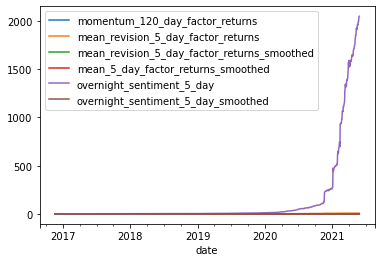

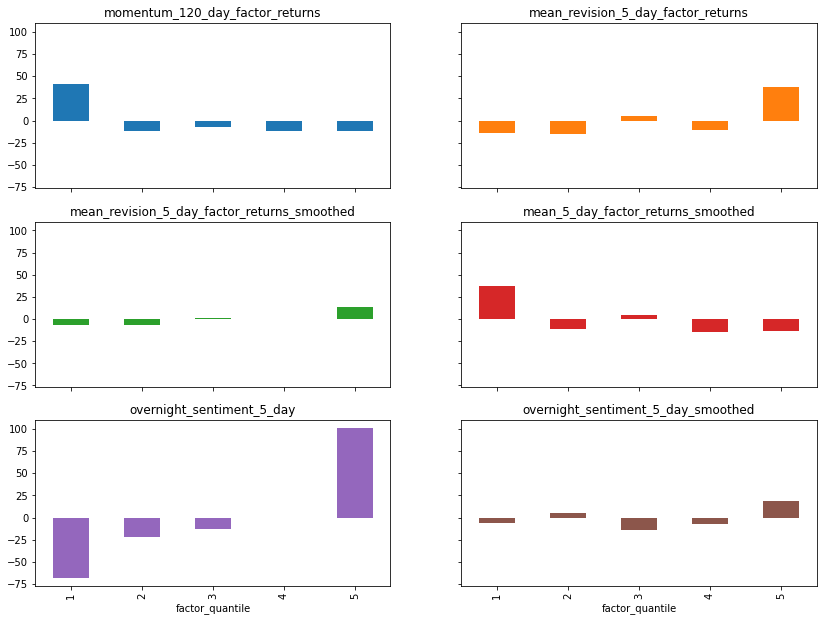

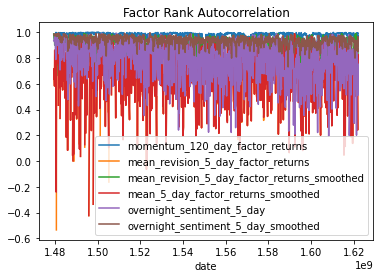

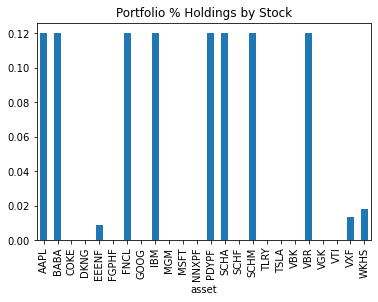

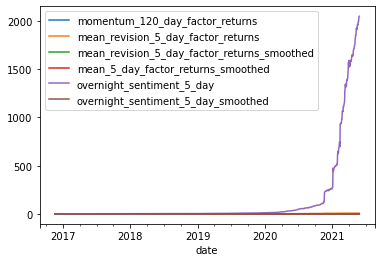

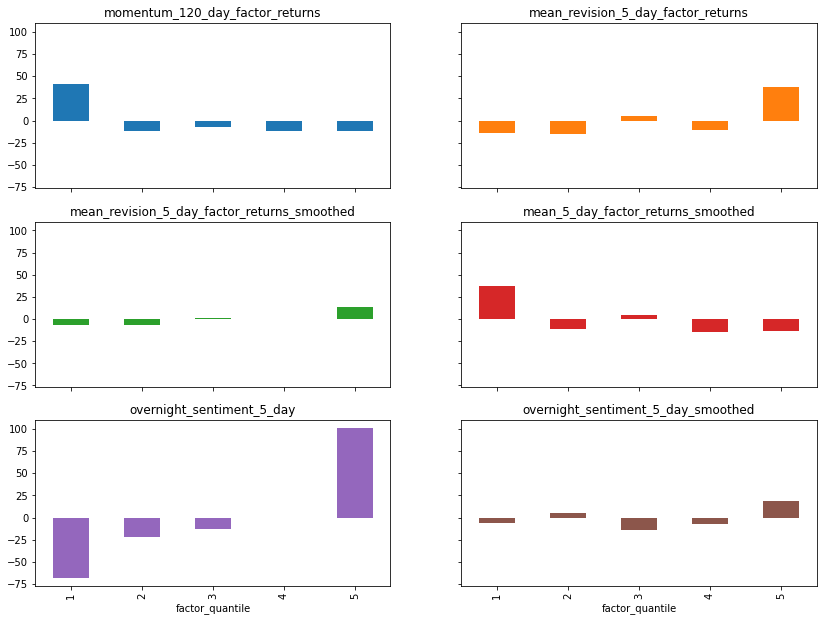

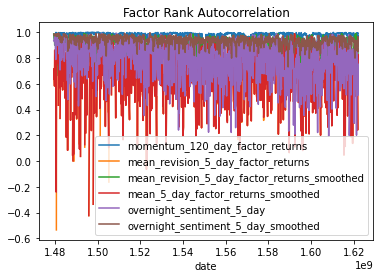

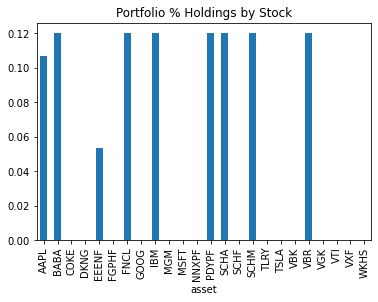

In [19]:
total_investiment = 115000
low_risk_investment = int(total_investiment * 0.75)
high_risk_investment = int(total_investiment * 0.25)

low_risk_long_port = generate_portfolio(low_risk_investment, stock_universe, portfolio_price_histories, risk_cap=.05)
display(low_risk_long_port)
high_risk_long_port = generate_portfolio(high_risk_investment, stock_universe, portfolio_price_histories, risk_cap=0.3)
display(high_risk_long_port)

## Alpha Factors

In [9]:
import trading_factors as alpha_factors
importlib.reload(alpha_factors)

all_factors = pd.concat(
    [
        alpha_factors.momentum(portfolio_price_histories, 120),
        alpha_factors.mean_revision_factor_returns(portfolio_price_histories, 5),
        alpha_factors.mean_revision_factor_returns_smoothed(portfolio_price_histories, 5),
        alpha_factors.overnight_sentiment(portfolio_price_histories, 5),
        alpha_factors.overnight_sentiment_smoothed(portfolio_price_histories, 5)
    ], axis=1)
all_factors.sort_index(inplace=True)

assets = all_factors.index.levels[1].values.tolist()
pricing = datafun.get_close_values(portfolio_price_histories)
clean_factor_data, unixt_factor_data = alpha_factors.prepare_alpha_lense_factor_data(all_factors, pricing)

Dropped 9.6% entries from factor data: 9.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.9% entries from factor data: 0.5% in forward returns computation and 2.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.4% entries from factor data: 0.8% in forward returns computation and 0.6% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


## PCA to compute portfolio variance

In [10]:
num_factor_exposures = 20
risk_model = alpha_factors.RiskModelPCA(returns, 1, num_factor_exposures)
print(f'portfolio variance is:  {risk_model.compute_portfolio_variance(sotck_universe_weights):.8f}')

portfolio variance is:  0.01973753


## Quantile Analysis
### Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

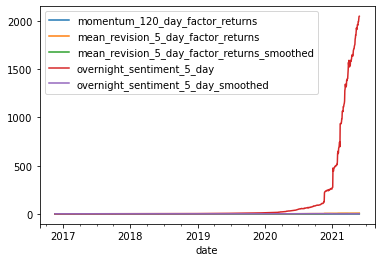

In [11]:
import alphalens as al

ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot()

### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\nmaiorana\anacond

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FFDE9FE470>,
      dtype=object)

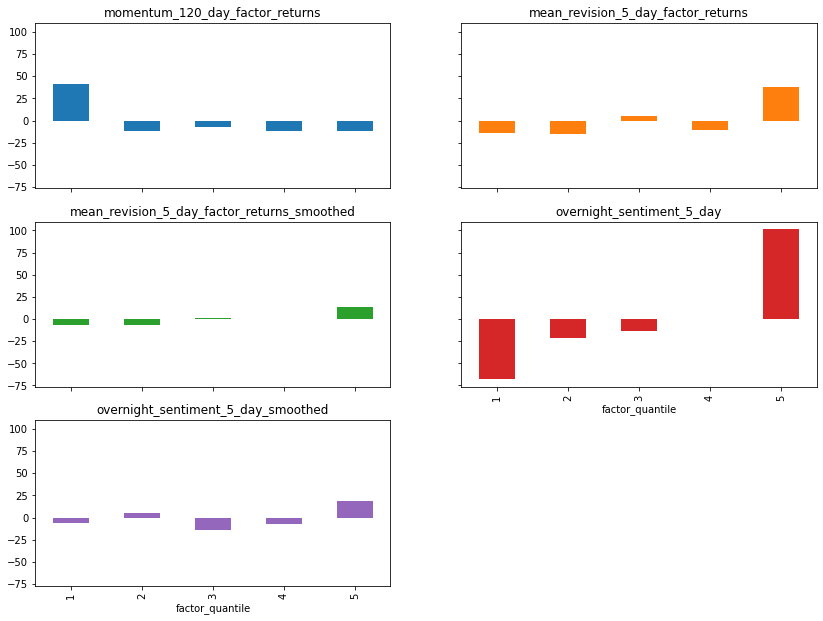

In [12]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

What do you observe?

- None of these alphas are **strictly monotonic**; this should lead you to question why this is? Further research and refinement of the alphas needs to be done. What is it about these alphas that leads to the highest ranking stocks in all alphas except MR 5D smoothed to *not* perform the best.
- The majority of the return is coming from the **short side** in all these alphas. The negative return in quintile 1 is very large in all alphas. This could also a cause for concern becuase when you short stocks, you need to locate the short; shorts can be expensive or not available at all.
- If you look at the magnitude of the return spread (i.e., Q1 minus Q5), we are working with daily returns in the 0.03%, i.e., **3 basis points**, neighborhood *before all transaction costs, shorting costs, etc.*. Assuming 252 days in a year, that's 7.56% return annualized. Transaction costs may cut this in half. As such, it should be clear that these alphas can only survive in an institutional setting and that leverage will likely need to be applied in order to achieve an attractive return.

## Turnover Analysis

Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **factor rank autocorrelation (FRA)**.

[alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

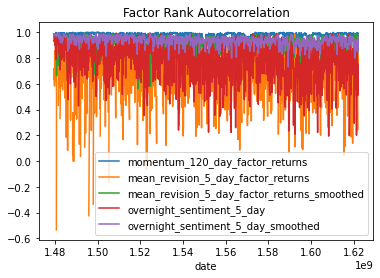

In [13]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

In [14]:
factfun.sharpe_ratio(ls_factor_returns, 'daily').round(2)

NameError: name 'factfun' is not defined

## The Combined Alpha Vector

To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. This is a area where machine learning can be very helpful. In this module, however, we will take the simplest approach of combination: simply averaging the scores from each alpha.

In [ ]:
selected_factors = all_factors.columns[[1, 3]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
alphas = all_factors[['alpha_vector']]
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]
alpha_vector
#alpha_vector.sort_values(by=['alpha_vector'], ascending=False)

# Optimal Portfolio Constrained by Risk Model
You have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model. You'll be building thie optimizer for this portfolio. To help you out. we have provided you with an abstract class called `AbstractOptimalHoldings`.

In [ ]:
from abc import ABC, abstractmethod
import cvxpy as cvx

class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T @ weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index, columns=['optimalWeights'])

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

In [ ]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)

        #TODO: Implement function
        
        return cvx.Maximize(alpha_vector.values.T @ weights)
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        #TODO: Implement function
        B = factor_betas
        constraints = [
            risk <= self.risk_cap ** 2,
            B.T @ weights <= self.factor_max,
            B.T @ weights >= self.factor_min,
            sum(weights) == 1.0,
            sum(cvx.abs(weights)) <= 1.0,
            weights <= self.weights_max,
            weights >= self.weights_min
        ]
        return constraints

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min


### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

In [ ]:
optimal_weights = OptimalHoldings(risk_cap=0.05,weights_max=0.12, weights_min=-0.12).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
print(f'Old portfolio variance is:  {risk_model.compute_portfolio_variance(sotck_universe_weights):.8f}')
print(f'New portfolio variance is:  {risk_model.compute_portfolio_variance(optimal_weights):.8f}')
display((optimal_weights*100).round(2))
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')

#x_axis = plt.axes().get_xaxis()
#x_axis.set_visible(False)

In [ ]:
investment_amount = portfun.get_account_value(stock_universe_values).round(2)
print(f'Current investment amount: {investment_amount}')
optimal_weights['amount'] = (optimal_weights['optimalWeights'] * investment_amount).round(0)
optimal_weights['marketValue'] = stock_universe_values['marketValue']
optimal_weights['buy/sell'] = (optimal_weights['marketValue'] - optimal_weights['amount']) * -1
optimal_weights['close'] = pricing.iloc[-1]
optimal_weights['existingShares'] = stock_universe_values['longQuantity']
optimal_weights['deltaShares'] = (optimal_weights['buy/sell'] / optimal_weights['close']).round(0)
optimal_weights['deltaMarketValue'] = (optimal_weights['deltaShares'] * optimal_weights['close'])
optimal_weights['totalShares'] = (optimal_weights['existingShares'] + optimal_weights['deltaShares'])
optimal_weights['totalMarketValue'] = (optimal_weights['totalShares'] * optimal_weights['close'])
optimal_weights

## Think or Swim Simulator

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] <= 0) & (optimal_weights['deltaShares'] == 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)][['deltaMarketValue', 'totalMarketValue']].sum().round(2)